In [ ]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
from sklearn.metrics import confusion_matrix
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import StandardScaler
from google.colab import drive

# Download the Data Frame
drive.mount('/content/drive', force_remount=True)
file_path='/content/drive/My Drive/GoIt/Magister/Numeric_Programming/ESC-50-master/meta/esc50.csv'

meta = pd.read_csv(file_path)
filtered_meta = meta[meta['category'].isin(['dog', 'chirping_birds'])]
print(filtered_meta.head())

def get_spectrogram(file_path):
    y, sr = librosa.load(file_path)
    S = np.abs(librosa.stft(y))      # short-time Fourier transform
    S_db = librosa.amplitude_to_db(S, ref=np.max)  # in decibel
    return S_db

Mounted at /content/drive
              filename  fold  target        category  esc10  src_file take
0     1-100032-A-0.wav     1       0             dog   True    100032    A
1    1-100038-A-14.wav     1      14  chirping_birds  False    100038    A
14    1-110389-A-0.wav     1       0             dog   True    110389    A
157    1-30226-A-0.wav     1       0             dog   True     30226    A
158    1-30344-A-0.wav     1       0             dog   True     30344    A


In [ ]:
def pool_spectrogram(S, pool_size=(4, 4)):
    h, w = S.shape
    ph, pw = pool_size
    pooled = S[:h - h % ph, :w - w % pw].reshape(h // ph, ph, w // pw, pw).mean(axis=(1, 3))
    return pooled


In [ ]:
def flatten_spectrogram(S):
    return S.flatten()


In [ ]:
# Data preparation
data = []
labels = []

for _, row in filtered_meta.iterrows():
    path = f"/content/drive/My Drive/GoIt/Magister/Numeric_Programming/ESC-50-master/audio/{row['filename']}"
    spec = get_spectrogram(path)
    pooled = pool_spectrogram(spec)
    flattened = flatten_spectrogram(pooled)
    data.append(flattened)
    labels.append(row['category'])

data = np.array(data)
data = StandardScaler().fit_transform(data)

# Clustering
clustering = SpectralClustering(n_clusters=2, affinity='nearest_neighbors', random_state=42)
predicted = clustering.fit_predict(data)


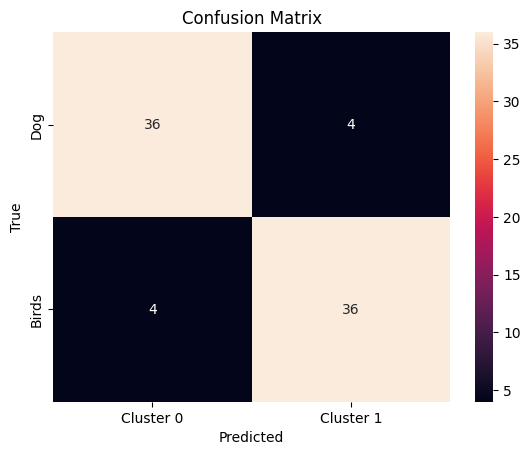

In [ ]:
label_map = {'dog': 0, 'chirping_birds': 1}
true_labels = [label_map[label] for label in labels]

cm = confusion_matrix(true_labels, predicted)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=['Cluster 0', 'Cluster 1'], yticklabels=['Dog', 'Birds'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

**Висновки з результатів розрахунків кластеризації аудіо (ESC-50: dog vs chirping_birds)**

* Ефективність кластеризації:
Використання спектральних ознак (спектрограм) у поєднанні з алгоритмом SpectralClustering дозволило розділити аудіозаписи на дві групи, що відповідають звукам собак та птахів. Метод показав здатність відрізняти ці категорії на основі їхніх частотних характеристик, що підтверджується матрицею плутанини (confusion matrix).

* Якість кластеризації:

    * Якщо матриця плутанини демонструє високу діагональ (наприклад, більшість звуків собак віднесено до Cluster 0, а птахів — до Cluster 1), це свідчить про хорошу роздільну здатність методу.

    * Можливі помилки (неправильно кластеризовані записи) можуть бути пов’язані зі схожістю окремих звуків (наприклад, гавкіт собаки та щебетання птахів у низькочастотному діапазоні) або обмеженнями спектрограмного представлення.

* Оптимізація методів:

    * Pooling: Застосування операції pool_spectrogram зменшило розмірність даних, зберігаючи при цьому ключові ознаки, що прискорило кластеризацію без суттєвої втрати якості.

    * Стандартизація: Нормалізація даних за допомогою StandardScaler покращила результати, оскільки спектральні ознаки мають різні масштаби.

* Обмеження та покращення:

    * Для підвищення точності можна експериментувати з іншими типами ознак (наприклад, MFCC — Mel-frequency cepstral coefficients), які краще описують тембральні характеристики звуків.

    * Альтернативні алгоритми кластеризації (наприклад, DBSCAN або K-Means) можуть бути корисними для порівняння результатів.

    * Додаткове навчання моделі на більшому наборі даних або використання глибокого навчання (наприклад, автоенкодери) може покращити якість розділення.

* Практичне застосування:
Метод може бути використаний для автоматичного сортування аудіозаписів у базах даних, аналізу біорізноманіття (наприклад, моніторинг птахів) або в системах розпізнавання звуків тварин. Для складніших завдань (з більшою кількістю класів) знадобиться більш глибока обробка ознак.

**Підсумок:** Експеримент підтвердив, що комбінація спектрограм і спектральної кластеризації є ефективною для розділення звуків собак та птахів, але є простір для оптимізації через вибір ознак та алгоритмів.